<a href="https://colab.research.google.com/github/polevev/kaggle/blob/main/%D0%A0%D0%BE%D0%B6%D0%B4%D0%B0%D0%B5%D0%BC%D0%BE%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('/content/rf_birthrate_dataset_full.csv')
df.sample(5)

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Браки,Разводы,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств
839,2019,Ингушетия,1.30,88400,50.4,307356,25.1,10.0,78.5,10.3,45078,4209,24.1,23.6,0.19
859,2019,Марий Эл,1.25,66461,54.9,538635,33.8,11.8,84.6,15.5,18653,36815,26.6,40.9,0.20
416,2014,Приморский край,1.18,62456,71.3,617903,25.2,9.3,59.6,14.0,92159,19025,25.5,15.9,0.44
826,2019,Алтайский край,1.13,94052,86.8,566558,28.9,8.5,79.0,13.5,53025,49082,23.1,30.5,0.25
545,2015,Ярославская область,1.16,73151,64.9,595728,36.5,8.1,81.2,11.5,14596,40107,27.9,30.6,0.29


In [2]:
df.describe()

,Год,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Браки,Разводы,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств
count,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000
mean,2016.500000,1.601813,73942.543956,73.126060,413755.927786,32.334380,6.985950,72.716562,11.967268,48386.098116,26156.496075,26.850157,28.001256,0.516256
std,4.032712,0.283485,31850.951629,13.396015,226527.631373,5.501254,2.911898,15.947922,2.323419,26454.990085,14347.613228,3.399961,8.095370,0.213797
min,2010.000000,1.100000,18030.000000,50.000000,5454.000000,23.000000,2.000000,45.000000,8.000000,3007.000000,1031.000000,21.000000,14.000000,0.150000
25%,2013.000000,1.360000,46569.500000,62.100000,220142.750000,27.500000,4.600000,58.800000,9.900000,25844.500000,13329.750000,23.900000,20.900000,0.330000
50%,2016.500000,1.605000,74865.500000,73.200000,406470.000000,32.200000,7.000000,72.800000,12.000000,48860.500000,26920.500000,26.700000,28.200000,0.520000
75%,2020.000000,1.840000,100874.500000,84.400000,613270.250000,37.000000,9.500000,86.600000,14.000000,71463.750000,38614.500000,29.700000,35.000000,0.700000
max,2023.000000,2.100000,129939.000000,95.900000,799186.000000,42.000000,12.000000,100.000000,16.000000,94968.000000,49973.000000,33.000000,42.000000,0.900000


In [4]:
from sklearn.preprocessing import LabelEncoder

scaler = LabelEncoder()

df['Регион'] = scaler.fit_transform(df['Регион'])

In [5]:
df

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Браки,Разводы,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств
0,2010,36,1.69,65408,85.2,764881,23.6,4.8,78.5,14.9,57016,47501,30.4,38.1,0.67
1,2010,67,1.13,87693,77.8,87881,41.8,8.5,70.3,8.6,14201,43197,31.4,25.7,0.66
2,2010,37,1.27,51566,89.0,669774,28.9,4.4,98.9,8.2,93589,49305,25.3,15.2,0.57
3,2010,31,1.84,34946,68.5,695238,30.8,8.9,85.6,10.6,5322,36630,25.0,25.2,0.62
4,2010,71,1.66,110735,78.5,489504,26.8,12.0,74.4,8.6,32765,2228,24.0,16.4,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,2023,85,1.62,125469,50.5,295880,37.9,6.0,60.1,8.0,77448,45559,29.8,32.3,0.65
1270,2023,86,1.28,107594,55.0,124096,36.6,10.9,70.2,11.9,79485,44067,27.7,15.0,0.62
1271,2023,87,1.86,116447,68.8,782396,34.6,11.6,88.0,10.3,78992,3434,32.0,40.1,0.25
1272,2023,88,1.41,51393,76.0,44252,29.6,10.8,93.6,11.4,59483,44638,25.6,41.7,0.25


In [6]:
df_1 = pd.DataFrame(df[df['Регион']==88],columns=df.columns)

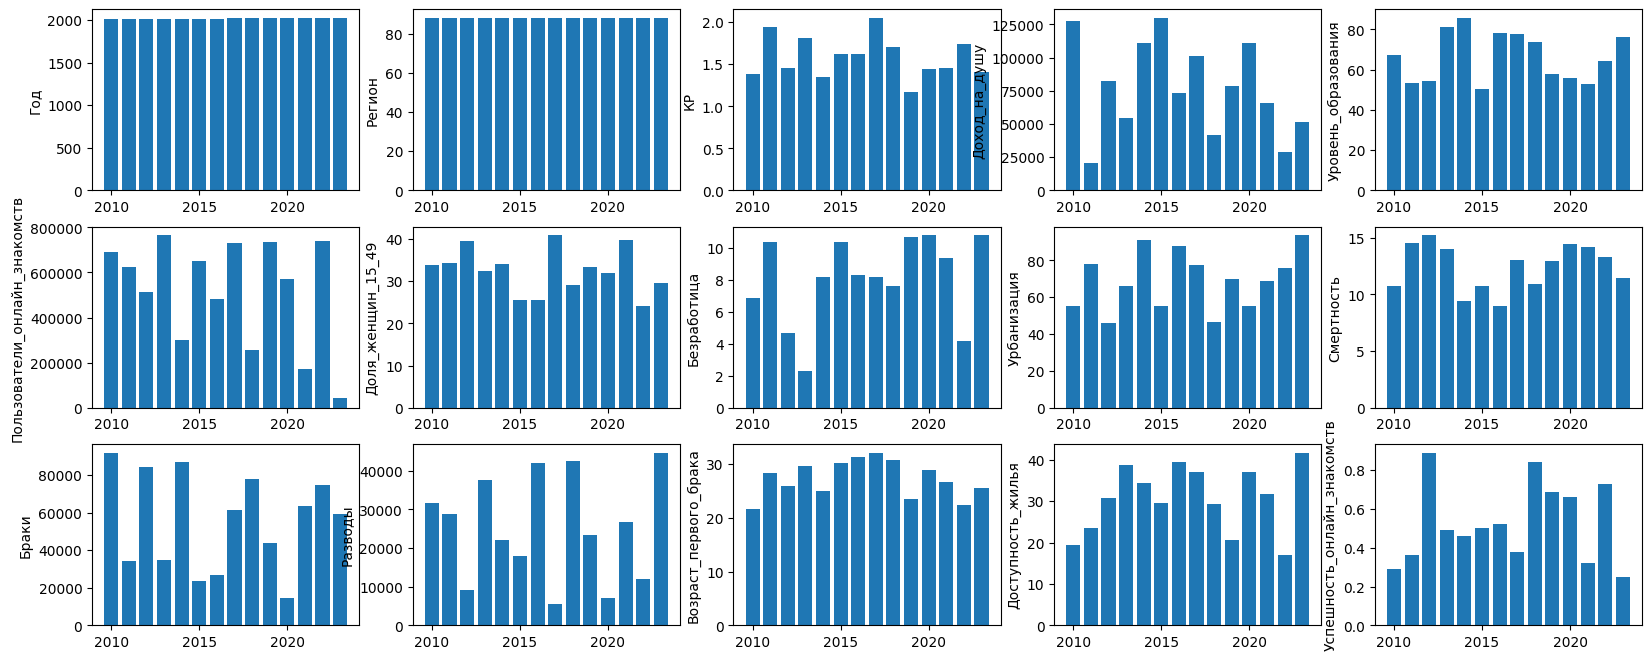

In [7]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(3, 5)
fig.set_size_inches(20, 8)
i = 0
j = 0
for column in df.columns:
  axes[i,j].bar(df_1['Год'], df_1[column])
  axes[i,j].set_ylabel(column)
  j+=1
  if j%5==0:
    i+=1
    j=0
plt.show()

In [8]:
df['Браки/разводы'] = df['Браки']/df['Разводы']

In [9]:
df.drop(columns=['Браки','Разводы'], inplace=True)

In [10]:
df

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств,Браки/разводы
0,2010,36,1.69,65408,85.2,764881,23.6,4.8,78.5,14.9,30.4,38.1,0.67,1.200312
1,2010,67,1.13,87693,77.8,87881,41.8,8.5,70.3,8.6,31.4,25.7,0.66,0.328750
2,2010,37,1.27,51566,89.0,669774,28.9,4.4,98.9,8.2,25.3,15.2,0.57,1.898164
3,2010,31,1.84,34946,68.5,695238,30.8,8.9,85.6,10.6,25.0,25.2,0.62,0.145291
4,2010,71,1.66,110735,78.5,489504,26.8,12.0,74.4,8.6,24.0,16.4,0.26,14.706014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,2023,85,1.62,125469,50.5,295880,37.9,6.0,60.1,8.0,29.8,32.3,0.65,1.699950
1270,2023,86,1.28,107594,55.0,124096,36.6,10.9,70.2,11.9,27.7,15.0,0.62,1.803731
1271,2023,87,1.86,116447,68.8,782396,34.6,11.6,88.0,10.3,32.0,40.1,0.25,23.002912
1272,2023,88,1.41,51393,76.0,44252,29.6,10.8,93.6,11.4,25.6,41.7,0.25,1.332564


<Axes: >

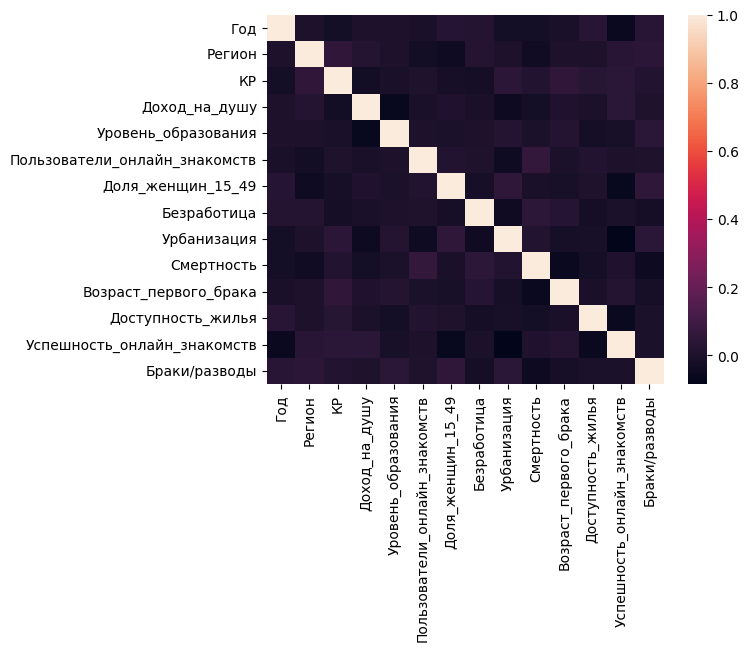

In [11]:
import seaborn as sns
sns.heatmap(df.corr(numeric_only=True))

In [12]:
df_origin = df.copy()

In [21]:
from sklearn.preprocessing import RobustScaler

Scaler =  RobustScaler()

df_origin = Scaler.fit_transform(df_origin)

In [22]:
df_origin = pd.DataFrame(df_origin, columns = df.columns)

In [23]:
df_origin

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств,Браки/разводы
0,-0.928571,-0.200000,0.177083,-0.174155,0.538117,0.911691,-0.905263,-0.448980,0.205036,0.707317,0.637931,0.702128,0.405405,-0.243275
1,-0.928571,0.488889,-0.989583,0.236212,0.206278,-0.810396,1.010526,0.306122,-0.089928,-0.829268,0.810345,-0.177305,0.378378,-0.575113
2,-0.928571,-0.177778,-0.697917,-0.429049,0.708520,0.669767,-0.347368,-0.530612,0.938849,-0.926829,-0.241379,-0.921986,0.135135,0.022425
3,-0.928571,-0.311111,0.489583,-0.735098,-0.210762,0.734540,-0.147368,0.387755,0.460432,-0.341463,-0.293103,-0.212766,0.270270,-0.644963
4,-0.928571,0.577778,0.114583,0.660519,0.237668,0.211214,-0.568421,1.020408,0.057554,-0.829268,-0.465517,-0.836879,-0.702703,4.898879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,0.928571,0.888889,0.031250,0.931839,-1.017937,-0.281308,0.600000,-0.204082,-0.456835,-0.975610,0.534483,0.290780,0.351351,-0.053043
1270,0.928571,0.911111,-0.677083,0.602679,-0.816143,-0.718276,0.463158,0.795918,-0.093525,-0.024390,0.172414,-0.936170,0.270270,-0.013530
1271,0.928571,0.933333,0.531250,0.765703,-0.197309,0.956244,0.252632,0.938776,0.546763,-0.414634,0.913793,0.843972,-0.729730,8.057835
1272,0.928571,0.955556,-0.406250,-0.432235,0.125561,-0.921375,-0.273684,0.775510,0.748201,-0.146341,-0.189655,0.957447,-0.729730,-0.192921


In [24]:
X = df_origin.drop(columns=['КР'])
y = df_origin['КР']

In [28]:
X_norm = df.drop(columns=['КР'])
y_norm = df['КР']

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2,stratify=y, random_state=42)

In [29]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm.values, y_norm.values, test_size=0.2,stratify=y_norm, random_state=42)

In [26]:
print(X_train.shape, X_test.shape)

(1019, 13) (255, 13)


In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'KNeighbors': KNeighborsRegressor(),
    'xgb': xgb.XGBRegressor(random_state=42)
}

In [38]:
from sklearn.model_selection import cross_validate
import numpy as np

results = {}

# Тестируем все модели
for name, model in models.items():
    # Расчет с несколькими метриками
    scoring = ['neg_mean_squared_error', 'r2']
    scores = cross_validate(model, X_train_norm, y_train_norm, cv=5, scoring=scoring)

    # Сохраняем результаты
    results[name] = {
        'MSE': -np.mean(scores['test_neg_mean_squared_error']),  # Инвертируем знак MSE
        'R²': np.mean(scores['test_r2'])
    }

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,MSE,R²
DecisionTree,0.165499,-1.076909
RandomForest,0.083077,-0.034675
LinearRegression,0.080986,-0.008075
SVR,0.081215,-0.011506
KNeighbors,0.095571,-0.194428
xgb,0.097553,-0.217787


In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Определяем модель
rf_model = RandomForestRegressor(random_state=42)

# Определяем параметры для поиска
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Количество деревьев
    'max_depth': [10, 20, 30],  # Максимальная глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное количество сэмплов для разбиения узла
    'min_samples_leaf': [2, 4, 6],  # Минимальное количество сэмплов в листе
    'max_features': ['auto', 'sqrt', 'log2'],  # Количество признаков для поиска лучшего разбиения
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=True)

# Обучение на данных
grid_search.fit(X_train_norm, y_train_norm)

# Вывод лучших параметров
print("Best parameters found: ", grid_search.best_params_)

# Оценка модели с лучшими гиперпараметрами
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print(f"Best score (MSE): {best_score:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
481 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py"

Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 200}
Best score (MSE): -0.0805


In [43]:
scoring = ['neg_mean_squared_error', 'r2']
scores = cross_validate(best_model, X_train_norm, y_train_norm, cv=5, scoring=scoring)
scores

{'fit_time': array([1.34723043, 1.06367373, 0.45456481, 0.46426058, 0.47024965]),
 'score_time': array([0.03939414, 0.02057123, 0.02394462, 0.01825285, 0.02151513]),
 'test_neg_mean_squared_error': array([-0.07736101, -0.07927886, -0.07200306, -0.0847357 , -0.08891167]),
 'test_r2': array([-0.00887347,  0.01399719, -0.00480509, -0.00612299, -0.00167683])}

In [51]:
y_pred = best_model.predict(X_test)

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
print(f'MAE:{mean_absolute_error(y_test, y_pred)}')
print(f'MSE:{mean_squared_error(y_test, y_pred)}')
print(f'R^2:{r2_score(y_test, y_pred)}')

MAE:1.6195425126967757
MSE:2.970552155616307
R^2:-7.54405009395596


In [57]:
import torch

In [88]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_classes, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32,1)
        )


    def forward(self, x):
      return (self.fc(x))

In [53]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

In [54]:
train_loader = torch.utils.data.DataLoader(list(zip(X_train_tensor, y_train_tensor)), batch_size=64, shuffle=True)

In [91]:
model = Net(num_classes=13)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [100]:
import matplotlib.pyplot as plt

In [105]:
import tqdm
from tqdm.auto import tqdm

def train_stochastic(model, loader, criterion, optimizer, num_epoch):
    # цикл по количеству эпох обучения
    total_epoch_loss = []
    for t in tqdm(range(num_epoch)):
        epoch_loss = []

        # цикл по батчам даталоадера
        for X_batch, y_batch in loader:
            # Вычислим предсказания нашей модели
            y_batch = y_batch.unsqueeze(1)
            y_pred = model(X_batch)

            # Посчитаем значение функции потерь  на полученном предсказании
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            # Выполним подсчёт новых градиентов
            loss.backward()
            # Выполним шаг градиентного спуска
            optimizer.step()
            # Обнулим сохраненные у оптимизатора значения градиентов
            # перед следующим шагом обучения
            optimizer.zero_grad()

        print(f"{t} epoch: curr_loss = {np.mean(epoch_loss)}")
        total_epoch_loss.append(epoch_loss)

    plt.figure(figsize=(10,8))
    plt.plot(range(1, num_epoch+1), total_epoch_loss, 'b-', linewidth=2)
    plt.title('Training Loss Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True)
    plt.show()

    return model

  0%|          | 0/500 [00:00<?, ?it/s]

0 epoch: curr_loss = 0.18485273141413927
1 epoch: curr_loss = 0.188884184230119
2 epoch: curr_loss = 0.1912989318370819
3 epoch: curr_loss = 0.1901785098016262
4 epoch: curr_loss = 0.17775365430861712
5 epoch: curr_loss = 0.1880556233227253
6 epoch: curr_loss = 0.19969801604747772
7 epoch: curr_loss = 0.17126799561083317
8 epoch: curr_loss = 0.18515096697956324
9 epoch: curr_loss = 0.1786497300490737
10 epoch: curr_loss = 0.17370301112532616
11 epoch: curr_loss = 0.18418444972485304
12 epoch: curr_loss = 0.18460656981915236
13 epoch: curr_loss = 0.18216537032276392
14 epoch: curr_loss = 0.17937202099710703
15 epoch: curr_loss = 0.18688328564167023
16 epoch: curr_loss = 0.17968190601095557
17 epoch: curr_loss = 0.18783692829310894
18 epoch: curr_loss = 0.18550130166113377
19 epoch: curr_loss = 0.19979788176715374
20 epoch: curr_loss = 0.18979207705706358
21 epoch: curr_loss = 0.19073261506855488
22 epoch: curr_loss = 0.19169144704937935
23 epoch: curr_loss = 0.19304927717894316
24 epoch

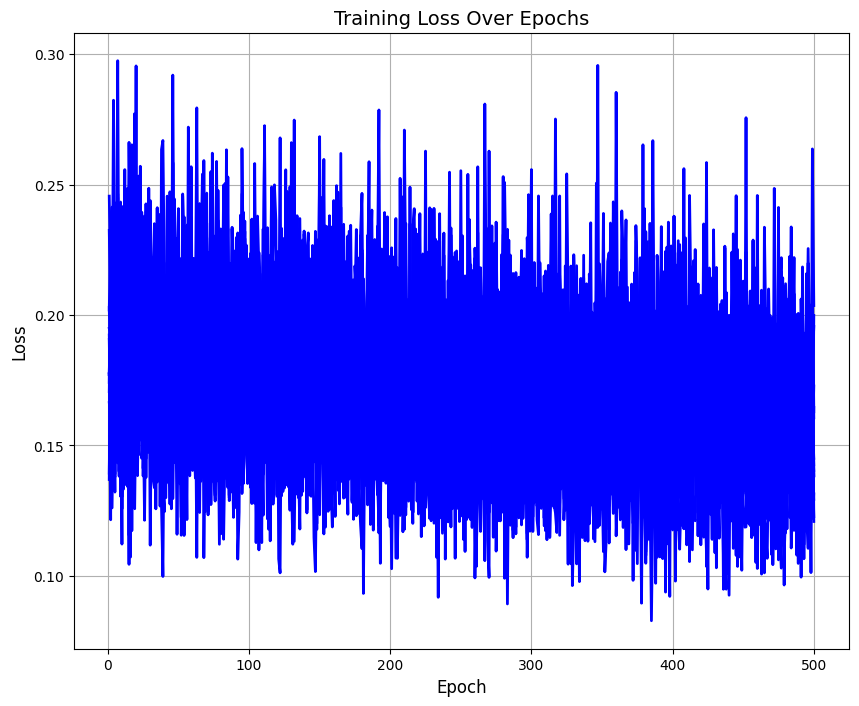

In [111]:
model = train_stochastic(model, train_loader, criterion, optimizer, 500)

In [107]:
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [112]:
with torch.no_grad():
    nn_prediction = model(torch.FloatTensor(X_test_tensor))
    nn_prediction = nn_prediction.tolist()

In [113]:
print(f'MAE:{mean_absolute_error(y_test, nn_prediction)}')
print(f'MSE:{mean_squared_error(y_test, nn_prediction)}')
print(f'R^2:{r2_score(y_test, nn_prediction)}')

MAE:0.5837928467229302
MSE:0.5070722199789305
R^2:-0.4584663799160176
